In [66]:
OBV = False
RSI_i = True
ManualSplit = True

In [67]:
import pandas as pd
from pandas_datareader import data, wb
import datetime
from pyspark import SQLContext
import matplotlib.pyplot as plt


def RSI(dataframe, column, window_length, avg_type):
    data = dataframe.toPandas()
    # Get just the close
    close = data[column]
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    if avg_type == "EWMA":
        roll_up = up.ewm(com=14).mean()
        roll_down = down.abs().ewm(com=14).mean()
    elif avg_type == "SMA":
        roll_up = pd.rolling_mean(up, window_length)
        roll_down = pd.rolling_mean(down.abs(), window_length)
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    from pyspark.sql.types import FloatType
    temp_df = spark.createDataFrame(data=RSI, schema=FloatType()).fillna(0)
    from pyspark.sql.functions import monotonically_increasing_id
    df1 = temp_df.repartition(1).select("*").withColumn(
        "id", monotonically_increasing_id())
    df1 = df1.withColumnRenamed('value', 'RSI')
    df2 = converted_df.select("*").withColumn("id",
                                              monotonically_increasing_id())
    joined_df = df1.join(df2, 'id')
    return joined_df.drop('id')

In [68]:
import findspark

findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql import functions as F

spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()
path_to_csv = "./Datasets/Orlen.csv"

fresh_df = spark.read.csv(path_to_csv, header=True, inferSchema=True)
df_cleared = fresh_df.drop("Adj Close")
# print(df_cleared.show())

df_lag = df_cleared.withColumn('prev_day_price',
                               func.lag(df_cleared['Close']).over(
                                   Window.orderBy("Date")))

# Previous day price
df_with_prev_day_price = df_lag.withColumn(
    'daily_return',
    (df_lag['Close'] - df_lag['prev_day_price']) / df_lag['Close'])

df_profit = df_with_prev_day_price.withColumn(
    'profit',
    (F.when(df_with_prev_day_price["daily_return"] < 0, 0).otherwise(1)))
# df_profit.show()

final_df = df_profit.where(df_profit["daily_return"].isNotNull())
# final_df.show()

final_df = final_df.drop("prev_day_price").withColumnRenamed(
    existing="daily_return", new="Daily return")

#Conversion to desired types
converted_df = final_df.select(
    final_df["Date"].cast("Date"), final_df["Open"].cast("float"),
    final_df["High"].cast("float"), final_df["Volume"].cast("int"),
    final_df["Low"].cast("float"), final_df["Close"].cast("float"),
    final_df["Daily return"].cast("float"), final_df["profit"].cast("int"))

In [69]:
# OBV indicator calculation
if OBV == True:
    temp_df = converted_df.toPandas()
    df_obv = spark.createDataFrame(
        temp_df.assign(OBV=(temp_df.Volume * (
            ~temp_df.Close.diff().le(0) * 2 - 1)).cumsum()))

    df_obv = df_obv.select(
        df_obv["Date"].cast("Date"), df_obv["Open"].cast("float"),
        df_obv["OBV"].cast("float"), df_obv["High"].cast("float"),
        df_obv["Volume"].cast("int"), df_obv["Low"].cast("float"),
        df_obv["Close"].cast("float"), df_obv["Daily return"].cast("float"),
        df_obv["profit"].cast("int"))
    converted_df = df_obv
    converted_df.show()

In [70]:
#RSI indicator calculaction
if RSI_i == True:
    converted_df = RSI(converted_df, "Close", 14, 'EWMA')
    converted_df.show()

+---------+----------+-----+-----+------+-----+-----+-------------+------+
|      RSI|      Date| Open| High|Volume|  Low|Close| Daily return|profit|
+---------+----------+-----+-----+------+-----+-----+-------------+------+
|      0.0|2012-05-29|7.802|7.809|     0|7.802|7.809|  0.013189909|     1|
|      0.0|2012-05-30| 7.95| 7.95|    10|7.782|7.782|-0.0034695452|     0|
|      0.0|2012-05-31|7.688|7.688|     0|7.688|7.688| -0.012226847|     0|
|      0.0|2012-06-01|7.526|7.526|   300|7.459|7.459| -0.030701166|     0|
|      0.0|2012-06-04|7.328|7.328|     0|7.328|7.328| -0.017876638|     0|
|30.760815|2012-06-05|7.514|7.514|     0|7.514|7.514|  0.024753792|     1|
|22.801466|2012-06-06|7.317|7.317|     0|7.317|7.317| -0.026923602|     0|
|  43.0114|2012-06-08|7.502|7.569|     0|7.502|7.569|  0.033293698|     1|
| 50.31181|2012-06-11|7.701|7.701|     0|7.701|7.701|   0.01714063|     1|
| 48.78986|2012-06-12|7.671|7.671|     0|7.671|7.671| -0.003910833|     0|
|60.154446|2012-06-13|7.9

In [71]:
#Convert date to splitted format
split_col = pyspark.sql.functions.split(converted_df['Date'], '-')
converted_df = converted_df.withColumn('Year',
                                       split_col.getItem(0).cast('int'))
converted_df = converted_df.withColumn('Month',
                                       split_col.getItem(1).cast('int'))
converted_df = converted_df.withColumn('Day', split_col.getItem(2).cast('int'))
converted_df = converted_df.drop("Date")
converted_df.show()

+---------+-----+-----+------+-----+-----+-------------+------+----+-----+---+
|      RSI| Open| High|Volume|  Low|Close| Daily return|profit|Year|Month|Day|
+---------+-----+-----+------+-----+-----+-------------+------+----+-----+---+
|      0.0|7.802|7.809|     0|7.802|7.809|  0.013189909|     1|2012|    5| 29|
|      0.0| 7.95| 7.95|    10|7.782|7.782|-0.0034695452|     0|2012|    5| 30|
|      0.0|7.688|7.688|     0|7.688|7.688| -0.012226847|     0|2012|    5| 31|
|      0.0|7.526|7.526|   300|7.459|7.459| -0.030701166|     0|2012|    6|  1|
|      0.0|7.328|7.328|     0|7.328|7.328| -0.017876638|     0|2012|    6|  4|
|30.760815|7.514|7.514|     0|7.514|7.514|  0.024753792|     1|2012|    6|  5|
|22.801466|7.317|7.317|     0|7.317|7.317| -0.026923602|     0|2012|    6|  6|
|  43.0114|7.502|7.569|     0|7.502|7.569|  0.033293698|     1|2012|    6|  8|
| 50.31181|7.701|7.701|     0|7.701|7.701|   0.01714063|     1|2012|    6| 11|
| 48.78986|7.671|7.671|     0|7.671|7.671| -0.003910

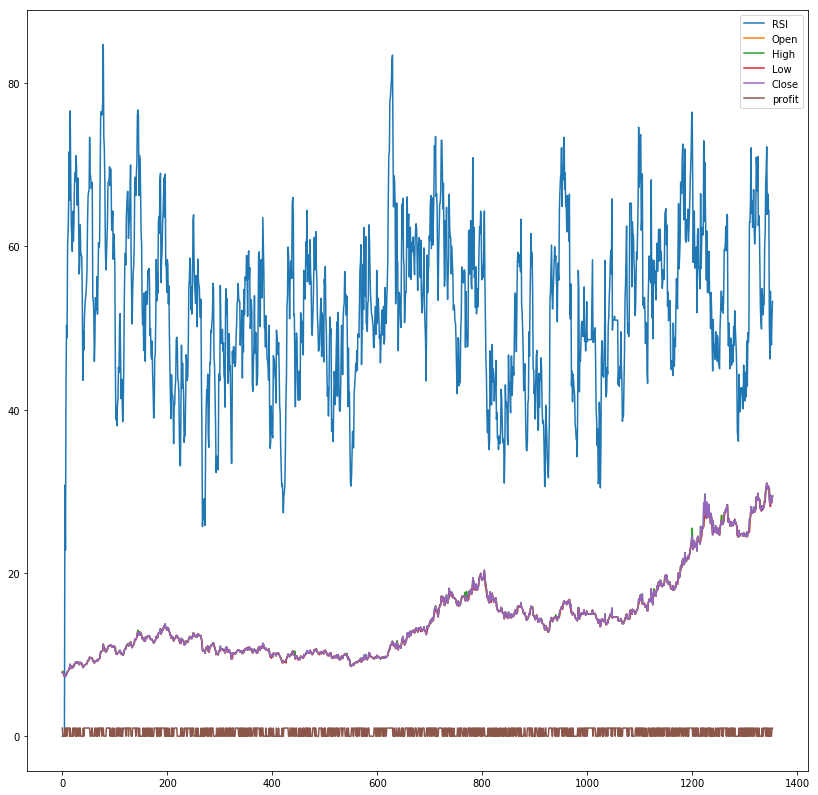

In [72]:
import numpy as np

# df_with_rsi.repartition(1).write.csv("test.csv")

df_to_plot_dt = converted_df.drop("Volume", 'Year', 'Month', 'Day',
                                 'Daily return').toPandas()
import matplotlib.pyplot as plt_dt
plt_dt.figure(figsize=(14, 14))
plt_dt.plot(df_to_plot_dt)
plt_dt.legend(df_to_plot_dt.columns)
plt_dt.show()

In [79]:
# Manuall split for training and validating data

if ManualSplit == True:
    dfp = converted_df.toPandas()

    dfp = np.array_split(dfp, 10)

    p0 = spark.createDataFrame(data=dfp[0])
    p1 = spark.createDataFrame(data=dfp[1])
    p2 = spark.createDataFrame(data=dfp[2])
    p3 = spark.createDataFrame(data=dfp[3])
    p4 = spark.createDataFrame(data=dfp[4])
    p5 = spark.createDataFrame(data=dfp[5])
    p6 = spark.createDataFrame(data=dfp[6])
    p7 = spark.createDataFrame(data=dfp[7])
    p8 = spark.createDataFrame(data=dfp[8])
    p9 = spark.createDataFrame(data=dfp[9])

    p_final = p0.union(p1).union(p2).union(p3).union(p4).union(p5).union(
        p6).union(p7).union(p8)
    train = p_final
    test = p9.head(10)
    test = spark.createDataFrame(test)
else:
    train, test = converted_df.randomSplit([0.9, 0.1])

print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))

# train.repartition(1).write.csv("train.csv")
# test.repartition(1).write.csv("test.csv")

We have 1219 training examples and 10 test examples.


In [74]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer

featuresCols = converted_df.columns
featuresCols.remove('profit')
print(featuresCols)

# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler_dt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
# This identifies categorical features and indexes them.
vectorIndexer_dt = VectorIndexer(
    inputCol="rawFeatures", outputCol="features", maxCategories=4)

['RSI', 'Open', 'High', 'Volume', 'Low', 'Close', 'Daily return', 'Year', 'Month', 'Day']


In [75]:
# Algorithm
from pyspark.ml.regression import RandomForestRegressor
dt = RandomForestRegressor(labelCol='Close', featuresCol="features")

In [76]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
# In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
# and more trees in the ensemble (>100).

max_Depth_Range = list(range(12, 15))
min_InstancesPerNode = list(range(2, 6))
# max_Bins = list(range(32, 48))

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, max_Depth_Range) \
    .addGrid(dt.maxMemoryInMB, [1500] ).build()
# .addGrid(dt.maxBins, max_Bins).build()
# .addGrid(dt.minInstancesPerNode,min_InstancesPerNode )\

# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.
evaluator_dt = RegressionEvaluator(
    metricName="rmse",
    labelCol=dt.getLabelCol(),
    predictionCol=dt.getPredictionCol())

evaluator_dt2 = RegressionEvaluator(
    metricName="mse",
    labelCol=dt.getLabelCol(),
    predictionCol=dt.getPredictionCol())

evaluator_dt3 = RegressionEvaluator(
    metricName="mae",
    labelCol=dt.getLabelCol(),
    predictionCol=dt.getPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_dt = CrossValidator(
    estimator=dt,
    evaluator=evaluator_dt,
    estimatorParamMaps=paramGrid_dt,
    numFolds=2)

In [77]:
# Creating Final pipeline object
pipeline_dt = Pipeline(stages=[vectorAssembler_dt, vectorIndexer_dt, cv_dt])

# FITTING!
pipelineModel_dt = pipeline_dt.fit(train)

# Making Predictions!
predictions_dt = pipelineModel_dt.transform(test)
# predictions_dt.show()

# from pyspark.sql.functions import col, avg
# avg_pred_error = predictions_dt.agg(avg(col("prediction")))

# Calculating metrics
mse_dt = evaluator_dt2.evaluate(predictions_dt)
rmse_dt = evaluator_dt.evaluate(predictions_dt)
mae_dt = evaluator_dt3.evaluate(predictions_dt)

# error = (rmse_dt / avg_pred_error) * 100

print("RMSE on our test set: %g" % mse_dt)
print("MSE on our test set: %g" % rmse_dt)
print("MAE on our test set: %g" % mae_dt)

df_to_plot_dt = predictions_dt.select('prediction','Close')

df_to_plot_dt.show()

import matplotlib.pyplot as plt_dt

df_to_plot_dt = df_to_plot_dt.toPandas()
plt_dt.figure(figsize=(14, 14))
plt_dt.plot(df_to_plot_dt)
plt_dt.legend(df_to_plot_dt.columns)
plt_dt.show()

AttributeError: 'list' object has no attribute '_jdf'